In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import sys
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Feature Correlation

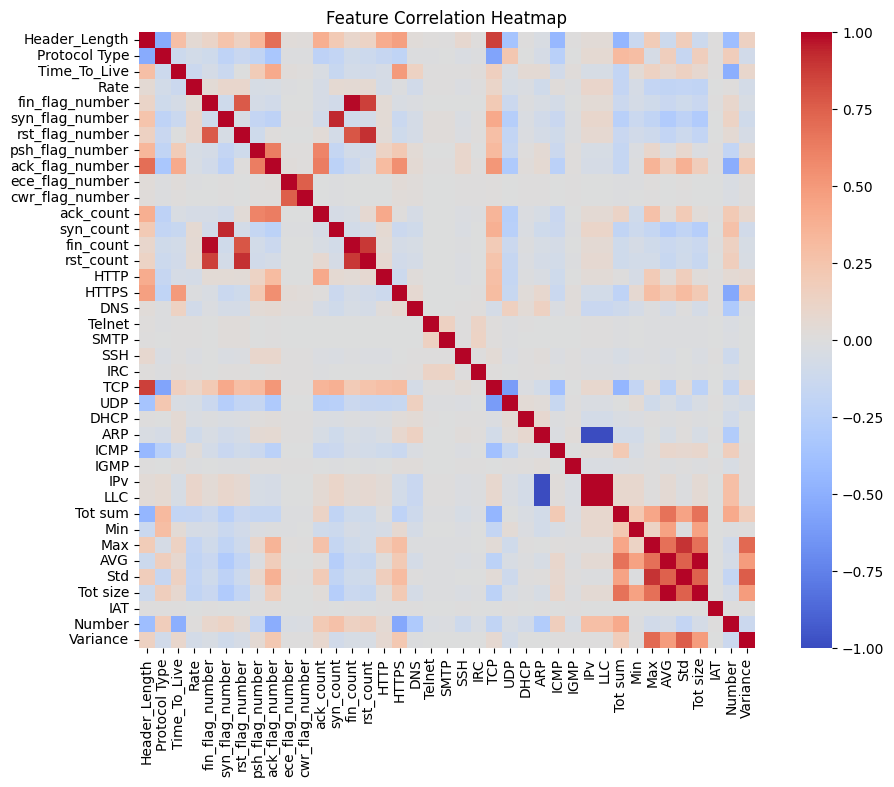

In [3]:
csv_path = "../data/processed/CIC_IOT_CSV_Dataset.csv"
df = pd.read_csv(csv_path)

categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.select_dtypes(include=['number']).columns.tolist()

plt.figure(figsize=(12, 8))
numeric_df = df.select_dtypes(include=['number'])
sns.heatmap(numeric_df.corr(), cmap="coolwarm", annot=False, square=True)
plt.title("Feature Correlation Heatmap")
plt.show()


# Feature Importance Study

/var/folders/09/s5nx4gn95nj0kqjmzvm1jcy00000gn/T/ipykernel_95115/769738.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importances.head(10), x="Importance", y="Feature", palette="viridis")


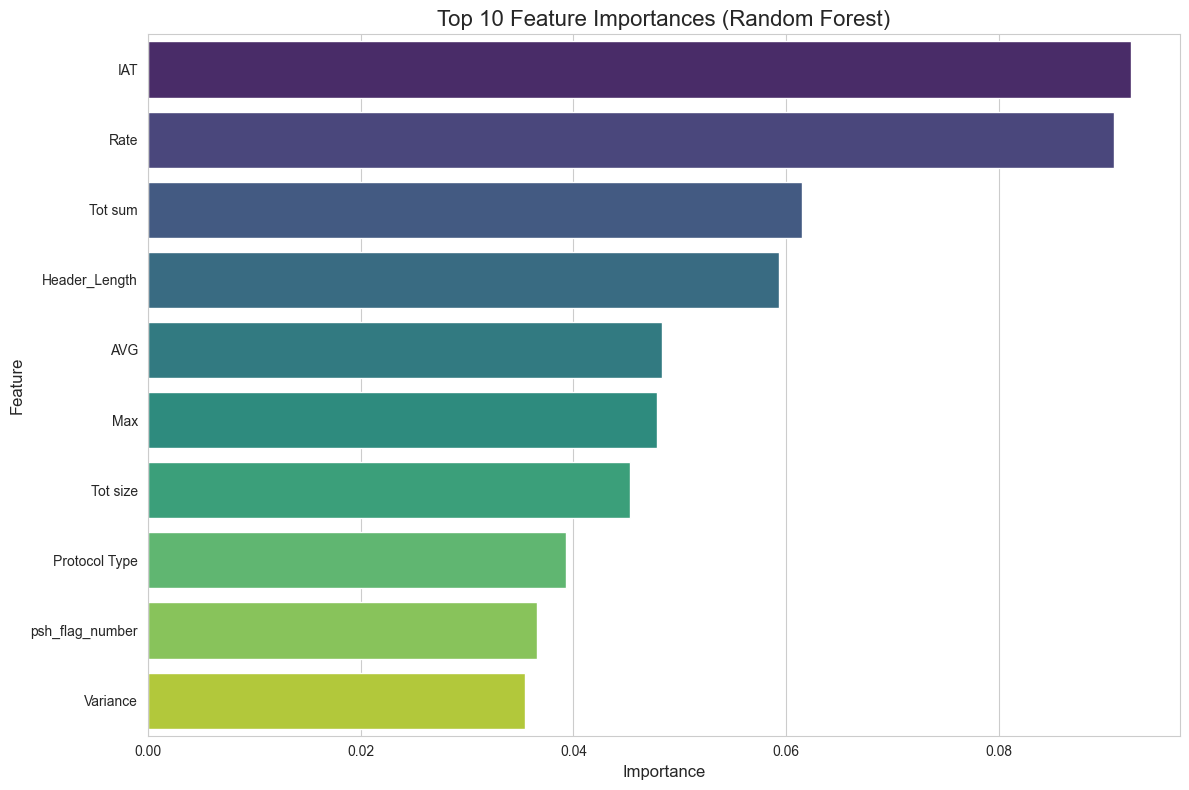

In [4]:
import pandas as pd

processed_data_path = "../data/processed/CIC_IOT_CSV_Dataset.csv"
df = pd.read_csv(processed_data_path)

df_sampled = df.sample(n=100000, random_state=42)
X = df_sampled.drop(columns=['label']).select_dtypes(include=['number'])
y = df_sampled['label']

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.set_style("whitegrid") 
sns.barplot(data=feature_importances.head(10), x="Importance", y="Feature", palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)", fontsize=16)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Feature", fontsize=12)
plt.tight_layout()
plt.show()



/var/folders/09/s5nx4gn95nj0kqjmzvm1jcy00000gn/T/ipykernel_95115/1931328073.py:27: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_plot = df_sampled.groupby('general_label').apply(lambda x: x.sample(n=min(250, len(x)), random_state=42)).reset_index(drop=True)


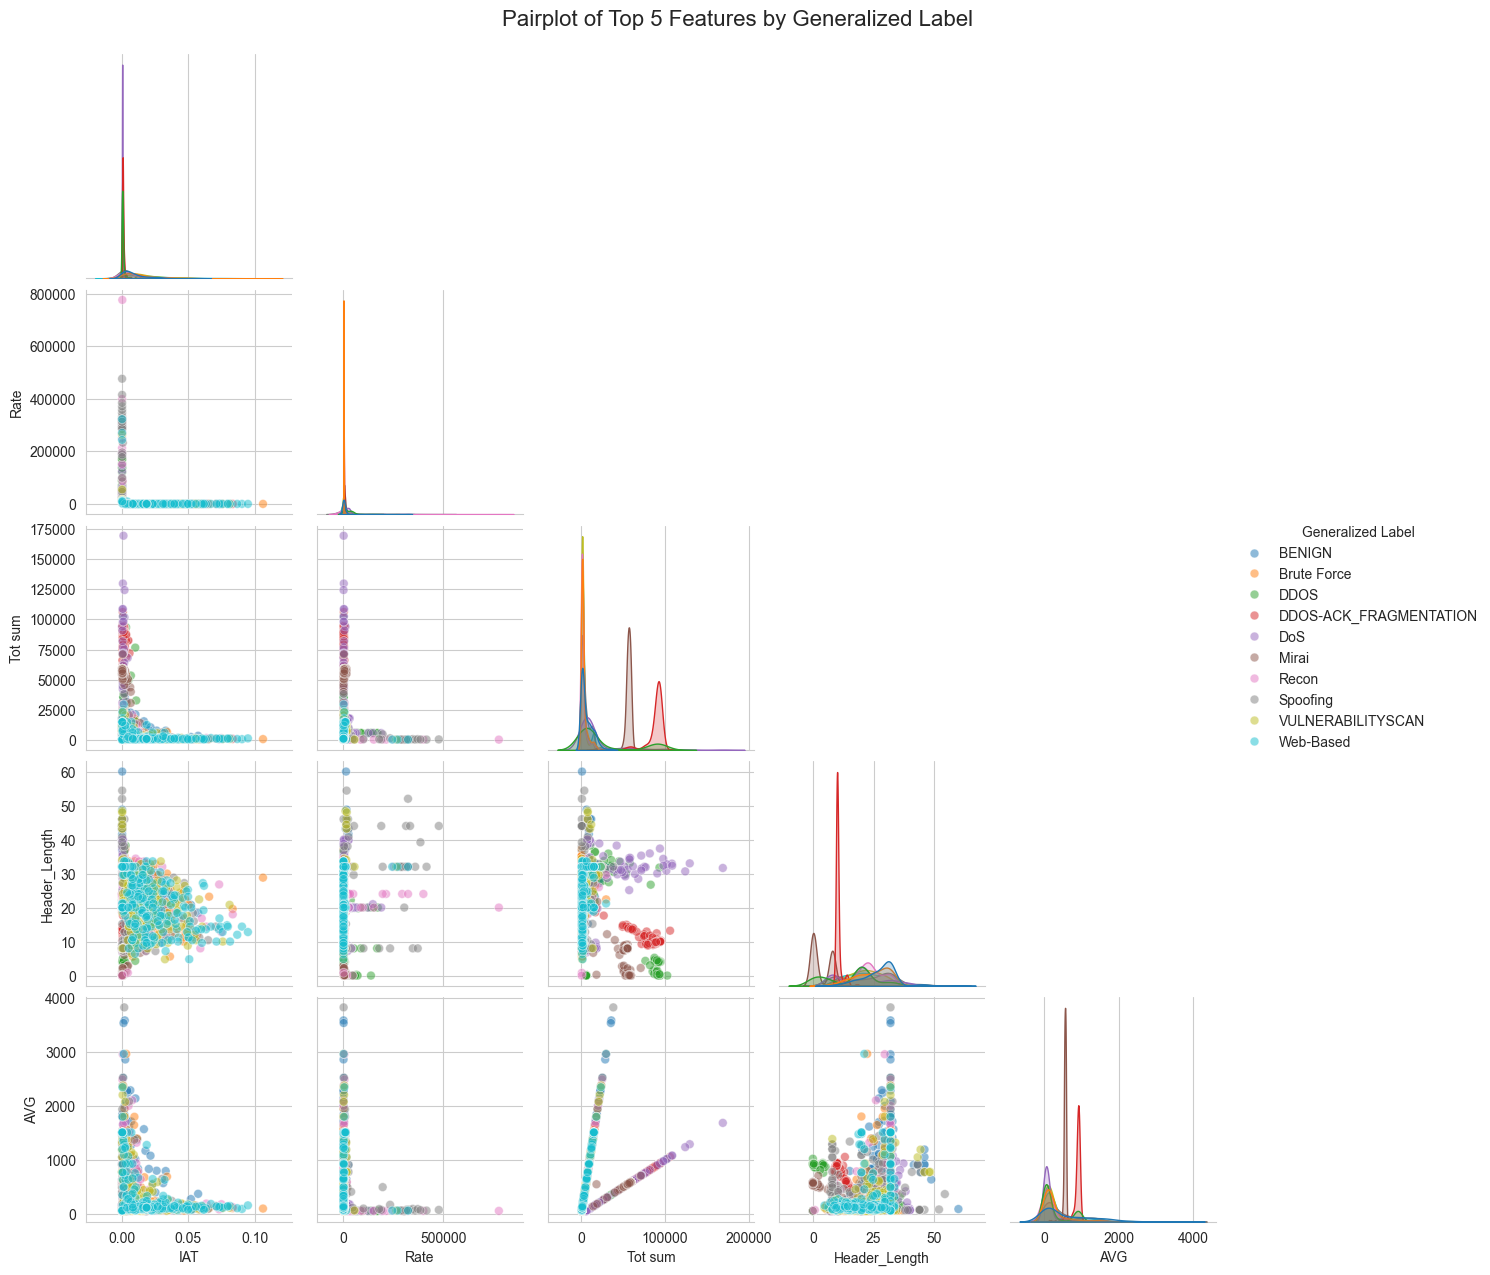

In [24]:
label_map = {
    'DDOS': ['DDOS-ACK_FRAGMENATION', 'DDOS-UDP_FLOOD', 'DDOS-SLOWLORIS', 'DDOS-ICMP_FLOOD', 'DDOS-RSTFINFLOOD',
             'DDOS-PSHACK_FLOOD', 'DDOS-HTTP_FLOOD', 'DDOS-UDP_FRAGMENTATION', 'DDOS-ICMP_FRAGMENTATION',
             'DDOS-TCP_FLOOD', 'DDOS-SYN_FLOOD', 'DDOS-SYNONYMOUSIP_FLOOD'],
    
    'DoS': ['DOS-TCP_FLOOD', 'DOS-HTTP_FLOOD', 'DOS-SYN_FLOOD', 'DOS-UDP_FLOOD'],

    'Recon': ['RECON-PINGSWEEP', 'RECON-OSSCAN', 'RECON-VULNERABILITYSCAN', 'RECON-PORTSCAN', 'RECON-HOSTDISCOVERY'],

    'Web-Based': ['SQLINJECTION', 'COMMANDINJECTION', 'BACKDOOR_MALWARE', 'UPLOADING_ATTACK', 'XSS', 'BROWSERHIJACKING'],

    'Brute Force': ['DICTIONARYBRUTEFORCE'],

    'Spoofing': ['MITM-ARPSPOOFING', 'DNS_SPOOFING'],

    'Mirai': ['MIRAI-GREIP_FLOOD', 'MIRAI-GREETH_FLOOD', 'MIRAI-UDPPLAIN']
}

flat_map = {}
for group, labels in label_map.items():
    for label in labels:
        flat_map[label] = group

df_sampled['general_label'] = df_sampled['label'].map(flat_map).fillna(df_sampled['label'])
y_general = df_sampled['general_label']

df_plot = df_sampled.groupby('general_label').apply(lambda x: x.sample(n=min(250, len(x)), random_state=42)).reset_index(drop=True)
top_features = feature_importances['Feature'].head(5).tolist()
g = sns.pairplot(df_plot[top_features + ['general_label']],
                 hue='general_label',
                 corner=True,
                 plot_kws={'alpha': 0.5, 's': 40})

g.figure.suptitle("Pairplot of Top 5 Features by Generalized Label", y=1.02, fontsize=16)
g.legend.set_title("Generalized Label")
plt.show()

Now we can try to visualize how well the top-5 features do at separating the labels. From the clustering you see below, this suggests the top 5 features you selected do a pretty good job separating attack types.

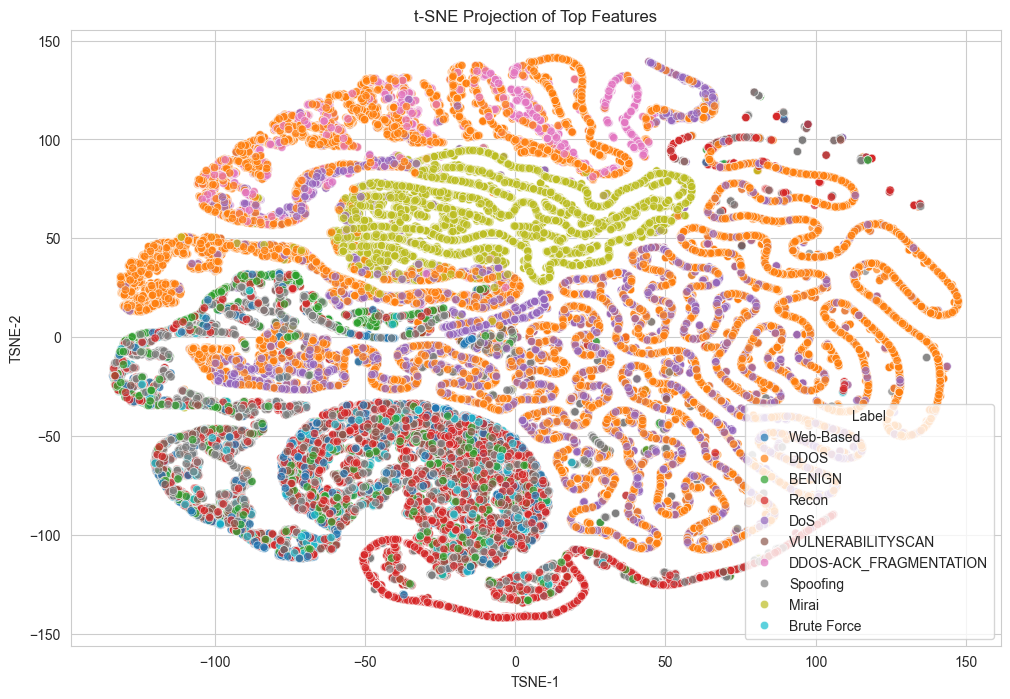

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=40, random_state=42)
X_embedded = tsne.fit_transform(df_sampled[top_features])

df_tsne = pd.DataFrame(X_embedded, columns=['TSNE-1', 'TSNE-2'])
df_tsne['Label'] = df_sampled['general_label'].values

plt.figure(figsize=(12, 8))
sns.scatterplot(data=df_tsne, x='TSNE-1', y='TSNE-2', hue='Label', alpha=0.7)
plt.title("t-SNE Projection of Top Features")
plt.show()

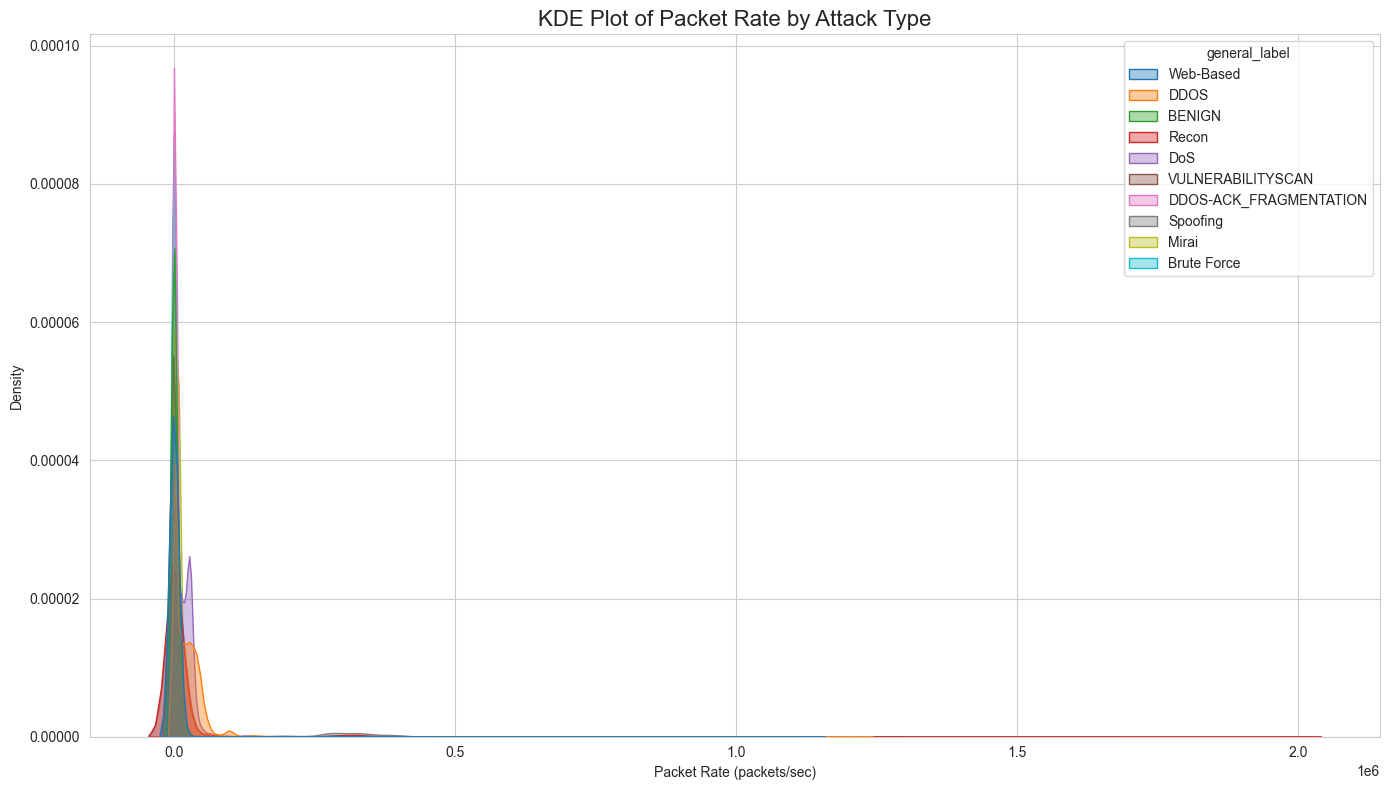

In [7]:
df_sampled = df_sampled[df_sampled['Rate'].notna()]
df_sampled = df_sampled[df_sampled['Rate'] > 0]
df_sampled['Rate'] = df_sampled['Rate'].astype(float)

# Create KDE without log scale to avoid transformation issues
plt.figure(figsize=(14, 8))
sns.kdeplot(data=df_sampled, x='Rate', hue='general_label', common_norm=False, fill=True, alpha=0.4, warn_singular=False)
plt.title("KDE Plot of Packet Rate by Attack Type", fontsize=16)
plt.xlabel("Packet Rate (packets/sec)")
plt.ylabel("Density")
plt.grid(True)
plt.tight_layout()
plt.show()

# Training a Model

In [8]:
!pip install tensorflow keras

Training a model based on all distinct attack types...

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, stratify=y, test_size=0.2, random_state=42)

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical

y_train_encoded = to_categorical(pd.factorize(y_train)[0])
y_test_encoded = to_categorical(pd.factorize(y_test)[0])

model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(64, activation='relu'),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


/Users/jle/dev/github.com/cybertoad/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 537us/step - accuracy: 0.5462 - loss: 1.3773 - val_accuracy: 0.6477 - val_loss: 0.8899
Epoch 2/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 498us/step - accuracy: 0.6391 - loss: 0.9013 - val_accuracy: 0.6648 - val_loss: 0.8675
Epoch 3/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6481 - loss: 0.8654 - val_accuracy: 0.6550 - val_loss: 0.8484
Epoch 4/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step - accuracy: 0.6550 - loss: 0.8461 - val_accuracy: 0.6724 - val_loss: 0.8363
Epoch 5/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 519us/step - accuracy: 0.6657 - loss: 0.8279 - val_accuracy: 0.6715 - val_loss: 0.8211
Epoch 6/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 506us/step - accuracy: 0.6815 - loss: 0.8036 - val_accuracy: 0.6933 - val_loss: 0.7987
Epoch 7/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 505us/step - accuracy: 0.6858 - loss: 0.7901 - val_accuracy: 0.6959 - val_loss: 0.7910
Epoch 8/20
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 522us/step - accuracy: 0.6907 - loss: 0.77

In [11]:
model.evaluate(X_test, y_test_encoded)

625/625 ━━━━━━━━━━━━━━━━━━━━ 0s 348us/step - accuracy: 0.0925 - loss: 22.1110


[21.829561233520508, 0.08990000188350677]

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
import numpy as np

# Use top 5 features
top_features = ['Rate', 'Tot sum', 'Header_Length', 'AVG', 'IAT']
X = df_sampled[top_features]
y = df_sampled['general_label'] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, stratify=y, test_size=0.2, random_state=42
)

y_train_factorized, class_names = pd.factorize(y_train)
y_test_factorized = pd.Series(y_test).map(dict(zip(class_names, range(len(class_names))))).fillna(-1).astype(int)
y_train_encoded = to_categorical(y_train_factorized)
y_test_encoded = to_categorical(y_test_factorized)

class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(zip(np.unique(y_train), class_weights))

model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train.shape[1],)),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.2),
    Dense(y_train_encoded.shape[1], activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    X_train,
    y_train_encoded,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    class_weight=class_weights_dict
)

loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/50


/Users/jle/dev/github.com/cybertoad/.venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 2s 688us/step - accuracy: 0.5935 - loss: 1.0979 - val_accuracy: 0.7087 - val_loss: 0.7254
Epoch 2/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - accuracy: 0.6924 - loss: 0.7463 - val_accuracy: 0.7082 - val_loss: 0.6997
Epoch 3/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 659us/step - accuracy: 0.6969 - loss: 0.7283 - val_accuracy: 0.7038 - val_loss: 0.7036
Epoch 4/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 649us/step - accuracy: 0.6995 - loss: 0.7140 - val_accuracy: 0.6984 - val_loss: 0.6962
Epoch 5/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 655us/step - accuracy: 0.7000 - loss: 0.7063 - val_accuracy: 0.7099 - val_loss: 0.6848
Epoch 6/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step - accuracy: 0.6996 - loss: 0.7101 - val_accuracy: 0.7078 - val_loss: 0.6879
Epoch 7/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 669us/step - accuracy: 0.7028 - loss: 0.7043 - val_accuracy: 0.7126 - val_loss: 0.6801
Epoch 8/50
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 1s 651us/step - accuracy: 0.7043 - loss: 0.69

In [23]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold

# Prepare data
top_features = ['Rate', 'Tot sum', 'Header_Length', 'AVG', 'IAT']
X = df_sampled[top_features].values
y_raw = df_sampled['label'].values

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw)
class_names = label_encoder.classes_

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Cross-validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
accuracies = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_scaled, y)):
    print(f"\n🔁 Fold {fold + 1}")

    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]

    # Sample weights
    sample_weights = compute_sample_weight('balanced', y_train)

    # Convert to DMatrix (required for xgb.train)
    dtrain = xgb.DMatrix(X_train, label=y_train, weight=sample_weights)
    dval = xgb.DMatrix(X_val, label=y_val)

    # Define parameters
    params = {
        'objective': 'multi:softprob',
        'num_class': len(np.unique(y)),
        'eval_metric': 'mlogloss',
        'learning_rate': 0.05,
        'max_depth': 7,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'seed': 42
    }

    # Train with early stopping
    evallist = [(dtrain, 'train'), (dval, 'eval')]
    model = xgb.train(
        params,
        dtrain,
        num_boost_round=500,
        evals=evallist,
        early_stopping_rounds=15,
        verbose_eval=False
    )

    # Predict
    y_pred_probs = model.predict(dval)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # Evaluate
    acc = accuracy_score(y_val, y_pred)
    accuracies.append(acc)
    print(f"✅ Accuracy: {acc:.4f}")
    print(classification_report(y_val, y_pred, target_names=class_names))

print(f"\n🎯 Average Accuracy: {np.mean(accuracies):.4f}")



🔁 Fold 1
✅ Accuracy: 0.5134
                         precision    recall  f1-score   support

       BACKDOOR_MALWARE       0.04      0.10      0.06        77
                 BENIGN       0.41      0.37      0.39       752
       BROWSERHIJACKING       0.12      0.20      0.15       142
       COMMANDINJECTION       0.12      0.21      0.15       131
 DDOS-ACK_FRAGMENTATION       0.97      0.98      0.98       744
        DDOS-HTTP_FLOOD       0.76      0.66      0.71       697
        DDOS-ICMP_FLOOD       1.00      1.00      1.00       744
DDOS-ICMP_FRAGMENTATION       0.97      0.95      0.96       751
      DDOS-PSHACK_FLOOD       0.17      0.15      0.16       738
       DDOS-RSTFINFLOOD       0.19      0.25      0.22       737
         DDOS-SLOWLORIS       0.67      0.82      0.73       581
DDOS-SYNONYMOUSIP_FLOOD       0.15      0.10      0.12       729
         DDOS-SYN_FLOOD       0.18      0.10      0.13       735
         DDOS-TCP_FLOOD       0.21      0.07      0.11      